# Final project guidelines

**Note:** Use these guidelines if and only if you are pursuing a **final project of your own design**. For those taking the final exam instead of the project, see the (separate) final exam notebook.

### The task

Your task is to: identify an interesting problem connected to the humanities or humanistic social sciences that's addressable with the help of computational methods, formulate a hypothesis about it, devise an experiment or experiments to test your hypothesis, present the results of your investigations, and discuss your findings.

These tasks essentially replicate the process of writing an academic paper. You can think of your project as a paper in miniature.

You are free to present each of these tasks as you see fit. You should use narrative text (that is, your own writing in a markdown cell), citations of others' work, numerical results, tables of data, and static and/or interactive visualizations as appropriate. Total length is flexible and depends on the number of people involved in the work, as well as the specific balance you strike between the ambition of your question and the sophistication of your methods. But be aware that numbers never, ever speak for themselves. Quantitative results presented without substantial discussion will not earn high marks. 

Your project should reflect, at minimum, ten **or more** hours of work by each participant, though you will be graded on the quality of your work, not the amount of time it took you to produce it. Most high-quality projects represent twenty or more hours of work by each member.

#### Pick an important and interesting problem!

No amount of technical sophistication will overcome a fundamentally uninteresting problem at the core of your work. You have seen many pieces of successful computational humanities research over the course of the semester. You might use these as a guide to the kinds of problems that interest scholars in a range of humanities disciplines. You may also want to spend some time in the library, reading recent books and articles in the professional literature. **Problem selection and motivation are integral parts of the project.** Do not neglect them.

### Format

You should submit your project as a PDF document created using the included $\LaTeX{}$ template. Consult the template for information on formatting and what is expected in each section. You can use your favorite text editor or something like [Overleaf](https://www.overleaf.com/) to edit this document. You will also submit this Jupyter notebook, along with all data necessary to reproduce your analysis. If your dataset is too large to share easily, let us know in advance so that we can find a workaround. 

All code used in the project should be present in the notebook (except for widely-available libraries that you import), but **be sure that we can read and understand your report in full without rerunning the code**. 

Because you are submitting essentially a mini-paper in the PDF writeup, I don't have any particular formatting expections for written material in this notebook. However, you should include **all code used when completing the final project, with comments added for clarity**. It should be straightforward to map code from the notebook to sections/figures/results in your paper, and vice versa.

### Grading

This project takes the place of the take-home final exam for the course. It is worth 35% of your overall grade. You will be graded on the quality and ambition of each aspect of the project. No single component is more important than the others.

### Practical details

* The project is due at **4:30 PM EST on Wednesday, December 17** via upload to CMS of a single zip file containing your fully executed Jupyter notebook report, a PDF copy of the notebook, and all associated data. **You may not use slip days for the final project or exam**. 
* You may work alone or in a group of up to three total members.
    * If you work in a group, be sure to list the names of the group members.
    * For groups, create your group on CMS and submit one notebook for the entire group. **Each group should also submit a statement of responsibility** that describes in general terms who performed which parts of the project.
* You may post questions on Ed, but should do so privately (visible to course staff only).

---

## Your info
* NetID(s): rr772, aa2289, kx63
* Name(s): Razika Rahman, Afran Ahmed, Kyleena Xin
---

In [33]:
# imports go here
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from   sklearn.decomposition import LatentDirichletAllocation


In [63]:
data = pd.read_csv("data/tedtalk_sample.csv")

data.head()

data_y = data['views']
data_for_vec = data.drop(columns=['views'])

In [ ]:
#Vectorizer

vectorizer = TfidfVectorizer(
    input = "content",
    encoding = "utf-8",
    stop_words = "english",
    strip_accents= "unicode",
    min_df= 10,
    max_df = 0.4,
    norm = 'l2',
    use_idf=True
)

#fit vectorizer onto corpus
data_vectorized = vectorizer.fit_transform(data_for_vec['transcript'])
print(f"Shape of Feature Matrix: {data_vectorized.shape}")

#store feature names + values
feature_name = vectorizer.get_feature_names_out()
val = data_vectorized.mean(axis = 0).A1

top_features = pd.DataFrame({
    "feature": feature_name,
    "value": val
}).sort_values("value", ascending = False)

top_features.head(30)

Shape of Feature Matrix: (1000, 7008)


,feature,value
6935,women,0.022334
1663,data,0.016306
6305,technology,0.015973
4193,music,0.015665
3596,kids,0.014302
5536,school,0.014285
5905,space,0.013952
1138,children,0.013839
6840,water,0.013707
3321,information,0.013679


In [95]:
#utilized from lecture 09
def print_top_words(model, feature_names, n_top_words, hide_stops=False):
    if hide_stops:
        from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic {topic_idx: >2}: "
        top_words_idx = topic.argsort()
        if not hide_stops:
            top_words = [feature_names[i]
                         for i in top_words_idx[:-n_top_words - 1:-1]]
        else:
            top_words = []
            i = 1
            while len(top_words) < n_top_words:
                if feature_names[top_words_idx[-i]] not in ENGLISH_STOP_WORDS:
                    top_words.append(feature_names[top_words_idx[-i]])
                i += 1
        message += " ".join(top_words)    
        print(message)
    print()

In [111]:
#LDA
lda = LatentDirichletAllocation(
    n_components= 7,
    n_jobs=-1,
    max_iter= 50,
    learning_method= 'batch',
    doc_topic_prior= 0.1,
    topic_word_prior= 0.01,
    evaluate_every=0,
    random_state=42
)

lda.fit(data_vectorized)

print_top_words(lda, vectorizer.get_feature_names_out(), n_top_words=10, hide_stops=False)

Topic  0: gun prison regret prisoners saturn torture uv grief prisons georgia
Topic  1: music patent jeans ends starts distorted zoom exists exhausting exhibit
Topic  2: technology water information health design energy country money food power
Topic  3: women data kids school space children brain music earth light
Topic  4: ghana baltimore hug thinker malnutrition expectancy existence executives exercise exhausted
Topic  5: universe star stars planets mars mathematics capture galaxy dinosaurs electric
Topic  6: neurons microbes ai muscle muscles antibiotics flies bone fruit interactive



In [108]:
#Regression
glr = LinearRegression(n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(data_vectorized, data_y,
    test_size = 0.2, random_state = 42
)

glr.fit(X_train, y_train)
y_pred = glr.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2 Score: -0.4913783940517167
MSE: 4606000300024.227


## Non-Textual Findings ##
First, using an unsupervised model like K means clustering, what kind of natural patterns are there in the data that surround high viewing TED Talks. 

Maybe additionally using PCA

And secondly using a supervised logistic regression model, using non-text features such as duration, recorded date, occupations, and other categorical columns, we want to predict whether a TED talk is popular or not. We define popular as a video that has higher than the median value of views. We also did some feature engineering, which included preserving the the top 25 jobs, and relabeling other jobs as "Other" due to the large number and variety. The most viewed TED talk had an astounding 56,932,551 views. And the least viewed TED Talk in the dataset had 119,999 views. After the cleaning, we had to convert all of these categorical features into binary indicators so our model could properly process them.

In [30]:
df = pd.read_csv("data/tedtalk_sample.csv")

#creating a popular/high views column to define what high views means in the dataset
df["high_views"] = (df["views"] > df["views"].median()).astype(int)

# polishing up the features to be easier to work with!
df["recorded_year"] = pd.to_datetime(df["recorded_date"]).dt.year
df["log_comments"] = np.log1p(df["comments"])
df["log_duration"] = np.log1p(df["duration"])

top_jobs = df["occupations"].value_counts().nlargest(25).index
df["occupation_clean"] = df["occupations"].where(
    df["occupations"].isin(top_jobs), "Other"
)

In [ ]:
#we dropped the first column here to avoid multi colinearity
X_categorical = pd.get_dummies(
    df[["occupation_clean"]],
    drop_first=True
)

X_num = df[["log_comments", "log_duration", "recorded_year"]]

X = pd.concat([X_num, X_categorical], axis=1)
y = df["high_views"]

#scaling the features so they all contribute and are weighted fairly
scaler = StandardScaler()
X[X_num.columns] = scaler.fit_transform(X[X_num.columns])

#logistic regression process as used in lecture 5
logit_clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

f1 = cross_val_score(
    logit_clf,
    X,
    y,
    scoring = "f1",
    cv = 5
)

print("Mean F1:", f1.mean())
print("Std F1:", f1.std())

logit_clf.fit(X, y)
y_logit = logit_clf.predict(X)
coef_df = (
    pd.DataFrame({
        "feature": X.columns,
        "coef": logit_clf.coef_[0]
    })
    .sort_values(by="coef", ascending=False)
)


Mean F1: 0.710672763091532
Std F1: 0.024162315679517096


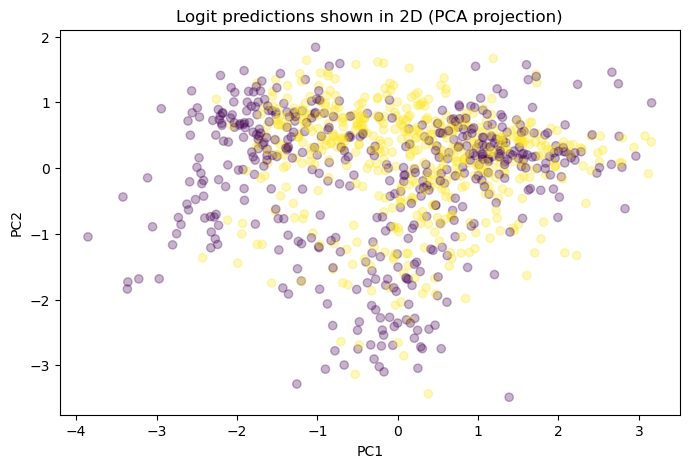

In [39]:
from sklearn.decomposition import PCA

X_2d = PCA(n_components=2, random_state=42).fit_transform(X.values)

logit_clf.fit(X, y)
y_pred = logit_clf.predict(X)

plt.figure(figsize=(8,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=y_pred, alpha=0.3)
plt.title("Logit predictions shown in 2D (PCA projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()